In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from segment_anything.build_sam import build_sam_vit_b
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from tqdm import tqdm
from dataset_processing.dataset import SAMDataset
from dataset_processing.preprocess import collate_fn
from utils.config import load_config

config = load_config('config.toml')
n_points = config.dataset.n_points
dataset_path = config.cytomine.dataset_path
batch_size = config.training.batch_size
prompt_type = {'points':config.dataset.points, 'box':config.dataset.box, 'neg_points':config.dataset.negative_points, 'mask':config.dataset.mask_prompt}
n_points = config.dataset.n_points
n_neg_points = config.dataset.n_neg_points
inside_box = config.dataset.negative_points_inside_box
points_near_center = config.dataset.points_near_center
random_box_shift = config.dataset.random_box_shift
mask_prompt_type = config.dataset.mask_prompt_type
box_around_mask = config.dataset.box_around_prompt_mask

prompt_type['points'] = False
prompt_type['neg_points'] = False

dataset = SAMDataset(dataset_path, prompt_type=prompt_type, n_points=n_points, n_neg_points=n_neg_points, verbose=True, to_dict=True, neg_points_inside_box=inside_box, points_near_center=points_near_center, random_box_shift=random_box_shift, mask_prompt_type=mask_prompt_type, box_around_mask=box_around_mask)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
model = build_sam_vit_b(config['sam']['checkpoint_path'])
model.to('cuda')
model.eval()
dice_scores = []





Loading images and masks paths...


Computing boxes...: 100%|██████████| 1538/1538 [00:06<00:00, 254.63it/s]


Done!


  0%|          | 0/1538 [00:01<?, ?it/s]


KeyError: 'mask_inputs'

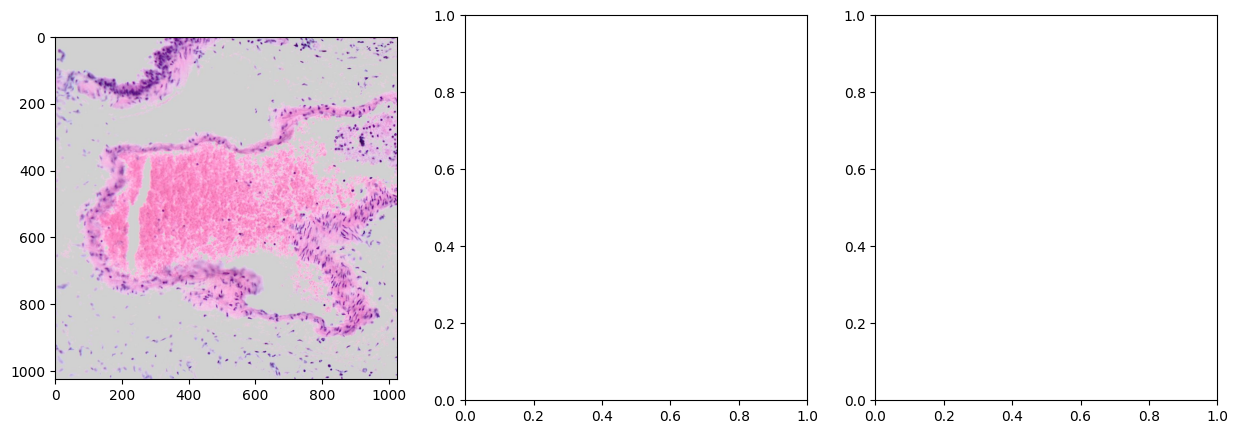

In [2]:
from cv2 import resize, INTER_NEAREST
with torch.no_grad():
    for data, mask in tqdm(dataloader):
        pred = model(data, multimask_output=True)
        for i in range(len(pred)):
            best_pred = pred[i]['masks'][0][pred[i]['iou_predictions'].argmax()].cpu().numpy()
            dice_scores.append(f1_score(mask[i].flatten(), np.array(best_pred.flatten(), dtype=np.uint8)))
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(np.array(data[i]['image'].cpu().permute(1, 2, 0).numpy(), dtype=np.uint8))
            #input_mask = resize(data[i]['mask_inputs'].cpu().numpy()[0][0], (1024, 1024), interpolation=INTER_NEAREST)
            #axes[0].imshow(input_mask, alpha=0.5)
            #print(np.max(input_mask), np.min(input_mask))
            #input_mask_dice = f1_score(mask[i].flatten(), np.where(np.array(input_mask.flatten(), dtype=np.uint8) >0, 1, 0))
            #gain = dice_scores[-1] - input_mask_dice
            #axes[0].scatter(data[i]['point_coords'][:, :n_neg_points, 0].cpu(), data[i]['point_coords'][:,:n_neg_points, 1].cpu(), c='g', s=10)
            #print(data[i]['point_coords'][:, n_points:, 0].cpu().shape)
            #axes[0].scatter(data[i]['point_coords'][:, n_points:, 0].cpu(), data[i]['point_coords'][:, n_points:, 1].cpu(), c='r', s=5)
            box = data[i]['boxes'][0].cpu().numpy()
            axes[1].add_patch(plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, edgecolor='b'))
            axes[1].imshow(mask[i])
            axes[2].imshow(best_pred)
            print(f'Dice : {dice_scores[-1]}')
            #print(f'Input mask Dice : {input_mask_dice}')
            #print(f'Gain : {gain}')
            plt.show()

print(f"Mean Dice score: {np.mean(dice_scores)}")